In [25]:
from typing import (
    Any, Callable, Iterable, Iterator, Sequence, Tuple, Union, cast
)

from cirq import ops, circuits

from cirq.contrib.paulistring.pauli_string_dag import (
    pauli_string_reorder_pred,
    pauli_string_dag_from_circuit)


def _possible_string_placements(
        possible_nodes: Iterable[Any],
        output_ops: Sequence[ops.Operation],
        key: Callable[[Any], ops.PauliStringPhasor] = lambda node: node.val,
) -> Iterator[Tuple[ops.PauliStringPhasor, int, circuits.
                    Unique[ops.PauliStringPhasor]]]:

    for possible_node in possible_nodes:
        string_op = key(possible_node)
        # Try moving the Pauli string through, stop at measurements
        yield string_op, 0, possible_node

        for i, out_op in enumerate(output_ops):
            if not set(out_op.qubits) & set(string_op.qubits):
                # Skip if operations don't share qubits
                continue
            if (isinstance(out_op, ops.PauliStringPhasor) and
                    out_op.pauli_string.commutes_with(string_op.pauli_string)):
                # Pass through another Pauli string if they commute
                continue
            if not (isinstance(out_op, ops.GateOperation) and
                    isinstance(out_op.gate, (ops.SingleQubitCliffordGate,
                                             ops.PauliInteractionGate,
                                             ops.CZPowGate))):
                # This is as far through as this Pauli string can move
                break
            string_op = string_op.pass_operations_over([out_op],
                                                       after_to_before=True)
            yield string_op, i+1, possible_node

        if len(string_op.pauli_string) == 1:
            # This is as far as any Pauli string can go on this qubit
            # and this Pauli string can be moved here.
            # Stop searching to save time.
            return

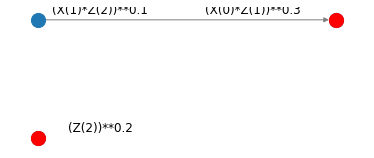

In [26]:
import networkx as nx 
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

def draw_dag(string_dag):
    plt.figure(3,figsize=(5,2)) 

    labels={n:str(n.val) for n in string_dag.nodes()}

    pos = graphviz_layout(string_dag, prog="dot")
    pos = {k : (-y,x) for (k, (x,y)) in pos.items()}
    nx.draw(string_dag, pos, node_size=200, edge_color='gray')
    pos_higher = {}
    y_off = 80 # offset on the y axis

    left = min(x for (k, (x,y)) in pos.items()) + 15
    for k, v in pos.items():
        pos_higher[k] = (max(left,v[0]-20), v[1]+y_off)

    nx.draw_networkx_labels(string_dag, pos_higher, labels, font_size=12)
    
    frontier = (set(string_dag.nodes())
                       - set(before for before, _ in string_dag.edges()))
    
    nx.draw_networkx_nodes(frontier, pos, node_color="red", node_size=200)

    plt.show()
    
draw_dag(string_dag)

In [27]:
c_orig

┌──────┐
0: ───@───────@───────@─────────@────@───X^0.3───
      │       │       │         │    │
1: ───@───────┼───@───@────X^0.1┼────@───────────
              │   │             │
2: ───Z^0.2───@───@─────────────@────────────────
                          └──────┘

In [28]:
cl

0: ───────────────────────[X]───────
                          │
1: ─────────────[X]───────[Z]^0.3───
                │
2: ───[Z]^0.2───[Z]^0.1─────────────

In [29]:
cr

0: ───@───@───────@───@───@───────
      │   │       │   │   │
1: ───@───┼───@───@───┼───@───────
          │   │       │
2: ───────@───@───────@───────────

In [30]:
while True:
    before_len = len(string_dag.nodes())
    pauli_string_optimize.merge_equal_strings(string_dag)
    pauli_string_optimize.remove_negligible_strings(string_dag)
    if len(string_dag.nodes()) >= before_len:
        break


rightmost_nodes = (set(string_dag.nodes())
                       - set(before for before, _ in string_dag.edges()))
draw_dag(string_dag)

NameError: name 'pauli_string_optimize' is not defined

In [31]:

for  n in rightmost_nodes: 
    print(str(n.val))

NameError: name 'rightmost_nodes' is not defined

In [32]:

for op, i, n in _possible_string_placements(rightmost_nodes, output_ops):
    print("{} -- {} -- {}".format(op, i, n.val))

NameError: name 'rightmost_nodes' is not defined

In [33]:
best_string_op, best_index, best_node = max(
            _possible_string_placements(rightmost_nodes, output_ops),
            key=lambda placement: (-len(placement[0].pauli_string),
                                   placement[1]))
print("{} -- {} -- {}".format(best_string_op, best_index, best_node.val))
# Place the best one into the output circuit
output_ops.insert(best_index, best_string_op)
# Remove the best one from the dag and update rightmost_nodes
rightmost_nodes.remove(best_node)
rightmost_nodes.update(
    pred_node
    for pred_node in string_dag.predecessors(best_node)
    if len(string_dag.succ[pred_node]) <= 1)
string_dag.remove_node(best_node)

NameError: name 'rightmost_nodes' is not defined

In [34]:
print(cirq.Circuit.from_ops(output_ops))

NameError: name 'output_ops' is not defined

In [35]:
c_orig

┌──────┐
0: ───@───────@───────@─────────@────@───X^0.3───
      │       │       │         │    │
1: ───@───────┼───@───@────X^0.1┼────@───────────
              │   │             │
2: ───Z^0.2───@───@─────────────@────────────────
                          └──────┘

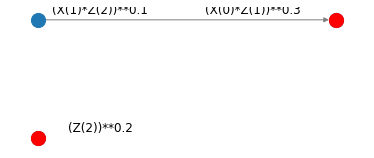

In [36]:
draw_dag(string_dag)

In [37]:
import cirq
import numpy as np

In [38]:
for i in range(3): 
    p1 = cirq.Pauli.by_index(i)
    p2 = cirq.Pauli.by_index(i+1)
    print()
    print("==========={}=============".format(p1))
    print()
    a,b = cirq.LineQubit.range(2)
    
    c1 = cirq.Circuit.from_ops([p1.on(a), p2.on(b), cirq.CZ(a,b)])
    print(c1)
   
    
    po = cirq.PauliString(qubit_pauli_map={a:p1, b:p2}).pass_operations_over([cirq.CZ(a,b)], after_to_before=True)

    c2 = cirq.Circuit.from_ops([cirq.CZ(a,b), cirq.decompose(po)])
    print(c2)
   
    print(np.all(np.isclose(cirq.unitary(c1), cirq.unitary(c2))))


===========X=============

0: ───X───@───
          │
1: ───Y───@───
0: ─────────────@───────Y───
                │
1: ─────────────@───────X───

global phase:   -1.0π
True

===========Y=============

0: ───Y───@───
          │
1: ───Z───@───
0: ───@───Y───
      │
1: ───@───────
True

===========Z=============

0: ───Z───@───
          │
1: ───X───@───
0: ───@───────
      │
1: ───@───X───
True


                          ┌──────┐
0: ───@───────@───────@─────────@────@───X^0.3───
      │       │       │         │    │
1: ───@───────┼───@───@────X^0.1┼────@───────────
              │   │             │
2: ───Z^0.2───@───@─────────────@────────────────
                          └──────┘
(Z(2))**0.2 -> (Z(2))**0.2
(X(1))**0.1 -> (X(1)*Z(2))**0.1
(X(0))**0.3 -> (X(0)*Z(1))**0.3


0: ───────────────────────[X]───────
                          │
1: ─────────────[X]───────[Z]^0.3───
                │
2: ───[Z]^0.2───[Z]^0.1─────────────


0: ───@───@───────@───@───@───────
      │   │       │   │   │
1: ───@───┼───@───@───┼───@───────
          │   │       │
2: ───────@───@───────@───────────


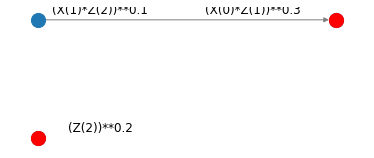

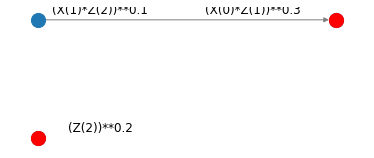

In [87]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from cirq.contrib.paulistring.pauli_string_optimize import * 
from cirq.contrib.paulistring.recombine import * 

from cirq import ops, circuits, optimizers

q0, q1, q2  = cirq.LineQubit.range(3)
c_orig = cirq.Circuit.from_ops(               
        ops.CZ(q0, q1),
        cirq.Z(q2)**0.2,
        ops.CZ(q2, q0),  
        ops.CZ(q1, q2),  
        ops.CZ(q1, q0),
        cirq.X(q1)**0.1,       
        ops.CZ(q2, q0),
        ops.CZ(q0, q1),
        cirq.X(q0)**0.3,       
)
print(c_orig)
# optimizers.MergeInteractions(allow_partial_czs=False).optimize_circuit(c_orig)
# print(c_orig)

cl, cr = convert_and_separate_circuit(c_orig,
                                          leave_cliffords=False,
                                          atol=1e-8)
print()
print()
print(cl)
print()
print()
print(cr)
string_dag = pauli_string_dag_from_circuit(cl)

draw_dag(string_dag)

# Merge and remove Pauli string phasors
while True:
    before_len = len(string_dag.nodes())
    merge_equal_strings(string_dag)
    remove_negligible_strings(string_dag)
    if len(string_dag.nodes()) >= before_len:
        break
        
draw_dag(string_dag)

In [40]:
c_new = move_pauli_strings_into_circuit_new(string_dag, cr)
c_new

0:    (X(0)*Z(1))**0.3 -> (X(0)*Z(1))**0.3 stepping over CZ(0, 1)
1:    (X(0)*Z(1))**0.3 -> (X(0))**0.3 stepping over CZ(2, 0)
2:    (X(0)*Z(1))**0.3 -> (X(0)*Z(2))**0.3 stepping over CZ(1, 2)
3:    (X(0)*Z(1))**0.3 -> (X(0)*Z(2))**0.3 stepping over CZ(1, 0)
4:    (X(0)*Z(1))**0.3 -> (X(0)*Z(1)*Z(2))**0.3 stepping over CZ(2, 0)
5:    (X(0)*Z(1))**0.3 -> (X(0)*Z(1))**0.3 stepping over CZ(0, 1)
0:    (Z(2))**0.2 -> (Z(2))**0.2 stepping over CZ(0, 1)
1:    (Z(2))**0.2 -> (Z(2))**0.2 stepping over CZ(2, 0)
2:    (Z(2))**0.2 -> (Z(2))**0.2 stepping over CZ(1, 2)
3:    (Z(2))**0.2 -> (Z(2))**0.2 stepping over CZ(1, 0)
4:    (Z(2))**0.2 -> (Z(2))**0.2 stepping over CZ(2, 0)
5:    (Z(2))**0.2 -> (Z(2))**0.2 stepping over CZ(0, 1)
got frontier: [('(Z(2))**0.2', 5), ('(X(0)*Z(1))**0.3', 6)]
0:    (X(1)*Z(2))**0.1 -> (X(1)*Z(2))**0.1 stepping over CZ(0, 1)
1:    (X(1)*Z(2))**0.1 -> (Z(0)*X(1)*Z(2))**0.1 stepping over CZ(2, 0)
2:    (X(1)*Z(2))**0.1 -> (Z(0)*X(1)*Z(2))**0.1 stepping over CZ(1, 2)


┌────────┐
0: ───@───@───────@───────────@────@─────────[X]^0.3───
      │   │       │           │    │
1: ───@───┼───@───@────[X]^0.1┼────@───────────────────
          │   │               │
2: ───────@───@───────────────@────[Z]^0.2─────────────
                      └────────┘

In [41]:
c_old=move_pauli_strings_into_circuit_old(string_dag, cr)
c_old

┌────────┐
0: ───@───@───────@───────────@────@─────────[X]^0.3───
      │   │       │           │    │
1: ───@───┼───@───@────[X]^0.1┼────@───────────────────
          │   │               │
2: ───────@───@───────────────@────[Z]^0.2─────────────
                      └────────┘

In [43]:
cirq.testing.assert_allclose_up_to_global_phase(cirq.unitary(c_orig), cirq.unitary(c_old), atol=1e-8)
cirq.testing.assert_allclose_up_to_global_phase(cirq.unitary(c_new), cirq.unitary(c_old), atol=1e-8)

In [44]:
ps = cirq.PauliStringPhasor(cirq.PauliString({q0:cirq.X}), exponent_pos=0.3)
str(ps)

'(X(0))**0.7'

In [45]:
print(ps.pauli_string.commutes_with(cirq.Y(q0)))
print(ps.pauli_string.commutes_with(cirq.Y(q1)))

False
True


In [46]:
ps2 = ps.pass_operations_over([cirq.SingleQubitCliffordGate.Y(q0)])
str(ps2)

'(X(0))**-0.7'

In [47]:
print(ps2.pauli_string.commutes_with(cirq.Y(q0)))
print(ps2.pauli_string.commutes_with(cirq.Y(q1)))

False
True


In [64]:
c = cirq.Circuit.from_ops(
    (cirq.Z(q1)*cirq.X(q2))**0.3,  # Operation [3]
    (cirq.PauliStringPhasor(cirq.PauliString({q2:cirq.X}), exponent_neg=0.2)),  # Operation [2]
    (cirq.Z(q0)*cirq.X(q1))**0.1,  # Operation [1]
)

In [74]:
cr = cirq.Circuit.from_ops(
    cirq.SingleQubitCliffordGate.Y_nsqrt(q1),
    cirq.CZ(q2, q1),
    cirq.SingleQubitCliffordGate.Y_sqrt(q1),
    cirq.SingleQubitCliffordGate.Z_sqrt(q2),
    cirq.SingleQubitCliffordGate.X_sqrt(q1),
    cirq.SingleQubitCliffordGate.X_sqrt(q1),
    cirq.SingleQubitCliffordGate.Y_sqrt(q0),
    cirq.CZ(q0, q1),
    cirq.SingleQubitCliffordGate.X_sqrt(q1),
    cirq.SingleQubitCliffordGate.Y_sqrt(q0),
    cirq.CZ(q1, q2),
    cirq.SingleQubitCliffordGate.Y_nsqrt(q0),
    cirq.CZ(q1, q0),
    cirq.SingleQubitCliffordGate.Y_sqrt(q0),
    cirq.SingleQubitCliffordGate.X_sqrt(q0),    
    cirq.SingleQubitCliffordGate.Y_nsqrt(q2),
    cirq.CZ(q0, q2),
    cirq.SingleQubitCliffordGate.Y_sqrt(q2),
    cirq.SingleQubitCliffordGate.X_sqrt(q0),
    strategy=cirq.InsertStrategy.NEW_THEN_INLINE,
)

In [75]:
dag = pauli_string_dag_from_circuit(c)

In [76]:
c

0: ─────────────[Z]───────
                │
1: ───[Z]───────[X]^0.1───
      │
2: ───[X]^0.3───[X]^0.2───

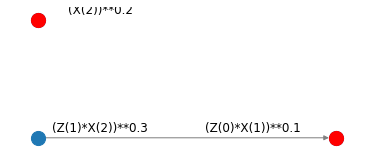

In [77]:
draw_dag(dag)

In [78]:
cr

0: ────────────────────────────────Y^0.5───@───Y^0.5───Y^-0.5───@───Y^0.5───X^0.5────@───X^0.5───
                                           │                    │                    │
1: ───Y^-0.5───@───Y^0.5───X^0.5───X^0.5───@───X^0.5───@────────@────────────────────┼───────────
               │                                       │                             │
2: ────────────@───Z^0.5───────────────────────────────@────────────────────Y^-0.5───@───Y^0.5───

In [81]:
c1 = move_pauli_strings_into_circuit_old(dag, cr)
c1

0:    (Z(0)*X(1))**0.1 -> (Z(0)*X(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+Z, Y:+Y, Z:-X)(1)
2:    (Z(0)*X(1))**0.1 -> (Z(0)*Z(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:-Z, Y:+Y, Z:+X)(1)
4:    (Z(0)*X(1))**0.1 -> (Z(0)*X(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+X, Y:+Z, Z:-Y)(1)
5:    (Z(0)*X(1))**0.1 -> (Z(0)*X(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+X, Y:+Z, Z:-Y)(1)
6:    (Z(0)*X(1))**0.1 -> (Z(0)*X(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:-Z, Y:+Y, Z:+X)(0)
8:    (Z(0)*X(1))**0.1 -> (Y(0)*Y(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+X, Y:+Z, Z:-Y)(1)
9:    (Z(0)*X(1))**0.1 -> (Y(0)*Z(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:-Z, Y:+Y, Z:+X)(0)
11:    (Z(0)*X(1))**0.1 -> (Y(0)*Z(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+Z, Y:+Y, Z:-X)(0)
13:    (Z(0)*X(1))**0.1 -> (Y(0))**0.1 stepping over cirq.SingleQubitCliffordGate(X:-Z, Y:+Y, Z:+X)(0)
14:    (Z(0)*X(1))**0.1 -> (Y(0))**0.1 s

0: ───Y^0.5─────────────────────────────────@───Y^0.5───Y^-0.5───@────────Y^0.5───X^0.5───@───X^0.5───[X]^-0.3───[Y]^-0.1───
                                            │                    │                        │
1: ───Y^-0.5────@───Y^0.5───X^0.5───X^0.5───@───X^0.5───@────────@────────────────────────┼─────────────────────────────────
                │                                       │                                 │
2: ───[X]^0.2───@───Z^0.5───────────────────────────────@────────Y^-0.5───────────────────@───Y^0.5─────────────────────────

In [82]:
c2 = move_pauli_strings_into_circuit_new(dag, cr)
c2

0:    (Z(0)*X(1))**0.1 -> (Z(0)*X(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+Z, Y:+Y, Z:-X)(1)
1:    (Z(0)*X(1))**0.1 -> (Z(0)*Z(1))**0.1 stepping over CZ(2, 1)
2:    (Z(0)*X(1))**0.1 -> (Z(0)*Z(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:-Z, Y:+Y, Z:+X)(1)
3:    (Z(0)*X(1))**0.1 -> (Z(0)*X(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+Y, Y:-X, Z:+Z)(2)
4:    (Z(0)*X(1))**0.1 -> (Z(0)*X(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+X, Y:+Z, Z:-Y)(1)
5:    (Z(0)*X(1))**0.1 -> (Z(0)*X(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+X, Y:+Z, Z:-Y)(1)
6:    (Z(0)*X(1))**0.1 -> (Z(0)*X(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:-Z, Y:+Y, Z:+X)(0)
7:    (Z(0)*X(1))**0.1 -> (X(0)*X(1))**0.1 stepping over CZ(0, 1)
8:    (Z(0)*X(1))**0.1 -> (Y(0)*Y(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:+X, Y:+Z, Z:-Y)(1)
9:    (Z(0)*X(1))**0.1 -> (Y(0)*Z(1))**0.1 stepping over cirq.SingleQubitCliffordGate(X:-Z, Y:+Y, Z:+X)(0)
10:    (Z(0)

0: ───Y^0.5─────────────────────────────────@───Y^0.5───Y^-0.5───@────────Y^0.5───X^0.5───@───X^0.5───[X]^-0.3───[Y]^-0.1───
                                            │                    │                        │
1: ───Y^-0.5────@───Y^0.5───X^0.5───X^0.5───@───X^0.5───@────────@────────────────────────┼─────────────────────────────────
                │                                       │                                 │
2: ───[X]^0.2───@───Z^0.5───────────────────────────────@────────Y^-0.5───────────────────@───Y^0.5─────────────────────────

Given a 
$$
\begin{align}
0 &= [U_A A U_A^\dagger, U_A U_B B U_B^\dagger U_A^\dagger] \\
  &= U_A A U_A^\dagger U_A U_B B U_B^\dagger U_A^\dagger - U_A U_B B U_B^\dagger U_A^\dagger U_A A U_A^\dagger \\
  & = U_A A U_B B U_B^\dagger U_A^\dagger - U_A U_B B U_B^\dagger A U_A^\dagger \\
  & = U_A ( A U_B B U_B^\dagger -  U_B B U_B^\dagger A) U_A^\dagger \\
  & = U_A [A, U_B B U_B^\dagger] U_A^\dagger
\end{align}
$$

Thus if A' and B' commute in the DAG, then A commutes with B when B is moved next to A, which means that $[U_A U_B B U_B^\dagger,  U_A A ] = 0 $, i.e it as long as we are checking for commutativity, it is impossible to cover that line with a paulistring. 




In [84]:
cirq.testing.assert_allclose_up_to_global_phase(cirq.unitary(c1), cirq.unitary(c2), atol=1e-8)

In [61]:
from cirq.contrib.paulistring.convert_gate_set import converted_gate_set

In [63]:
converted_gate_set(cirq.Circuit.from_ops([cirq.CNOT(q2,q1)]))

1: ───Y^-0.5───@───Y^0.5───
               │
2: ────────────@───────────

In [86]:
(cirq.PauliStringPhasor(cirq.PauliString({q1:cirq.Z, q2:cirq.X}), exponent_neg=0.3)).pauli_string.commutes_with(
(cirq.PauliStringPhasor(cirq.PauliString({q2:cirq.X}), exponent_neg=0.2)).pauli_string)

True